In [1]:
import json
import os
import re

In [2]:
#ściezka z danymi origin
#input_folder_orig = r'C:\Users\Adam\Desktop\ONS\data\chopin\orig'
input_folder_orig = r'A:\repo_git\ONS\data\chopin\orig'

#lista plikow origin
file_list_orig = ['1.json', '2.json', '3.json', '4.json', '5.json', '6.json','7.json', '8.json', '9.json', '10.json', '11.json', '12.json']

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ścieżki do plików
airports_csv = r'A:\repo_git\ONS\data\combined_iata_icao.csv'
countries_csv = r'A:\repo_git\ONS\data\all1.csv'

#airports_csv = r'C:\Users\Adam\Desktop\ONS\data\combined_iata_icao.csv'
#countries_csv = r'C:\Users\Adam\Desktop\ONS\data\all.csv'

# Wczytanie danych lotnisk z pliku CSV
airports_df = pd.read_csv(airports_csv)
countries_df = pd.read_csv(countries_csv)

# Usunięcie dodatkowych znaków białych
countries_df['alpha-2'] = countries_df['alpha-2'].str.strip()

# Usunięcie cudzysłowów
countries_df['alpha-2'] = countries_df['alpha-2'].str.replace('"', '')

# Mapowanie krajów na pełne nazwy krajów
country_code_to_name = countries_df.set_index('alpha-2')['name'].to_dict()

# Sprawdzenie
#print(country_code_to_name)


# Mapowanie krajów na kod ICAO lotnisk
icao_to_country_code = airports_df.set_index('icao')['country_code'].to_dict()
country_code_to_name = countries_df.set_index('alpha-2')['name'].to_dict()
country_code_to_continent = countries_df.set_index('alpha-2')['region'].to_dict()
country_code_to_region = countries_df.set_index('alpha-2')['sub-region'].to_dict()


# Tworzenie listy do przechowywania wyników
all_flights = []

# Przetwarzanie plików z listy origin
for filename in file_list_orig:
    input_file_path = os.path.join(input_folder_orig, filename)

    with open(input_file_path, 'r', encoding='utf-8') as infile:
        for line in infile:
            try:
                data = json.loads(line)
                all_flights.append(data)
            except json.JSONDecodeError:
                print(f"Błąd dekodowania JSON w pliku {filename}, linia: {line}")

# Konwersja listy do DataFrame
df = pd.DataFrame(all_flights)

# Konwersja kolumny 'pitr' do formatu datetime
df['pitr'] = pd.to_datetime(df['pitr'])

# Dodanie kolumny 'month' na podstawie 'pitr'
df['month'] = df['pitr'].dt.month

# Zastąpienie kodów ICAO kodami krajów
df['dest_country_code'] = df['dest'].map(icao_to_country_code).fillna(df['dest'])

# Zastąpienie kodow panstw, nazwami panstw
df['dest_country'] = df['dest_country_code'].map(country_code_to_name).fillna(df['dest_country_code'])

# Zastąpienie kodow panstw, kontynentami
df['dest_continent'] = df['dest_country_code'].map(country_code_to_continent).fillna(df['dest_country_code'])

# Zastąpienie kodow panstw,  regionami kontynentów
df['dest_region'] = df['dest_country_code'].map(country_code_to_region).fillna(df['dest_country_code'])


In [4]:
# Znalezienie niezmapowanych kodów ICAO
unmapped_icao = []

for icao_code in df['dest_country_code'].unique():
    if icao_code not in country_code_to_name:
        unmapped_icao.append(icao_code)

# Wypisanie niezmapowanych kodów ICAO
print("Niezmapowane kody ICAO:")
for icao_code in unmapped_icao:
    print(icao_code)


Niezmapowane kody ICAO:


In [5]:
# Mapowanie na polskie nazwy pór roku
season_map = {
    1: 'Zima', 2: 'Zima', 3: 'Wiosna',
    4: 'Wiosna', 5: 'Wiosna', 6: 'Wiosna',
    7: 'Lato', 8: 'Lato', 9: 'Lato',
    10: 'Jesień', 11: 'Jesień', 12: 'Zima'
}
df['season'] = df['month'].map(season_map)


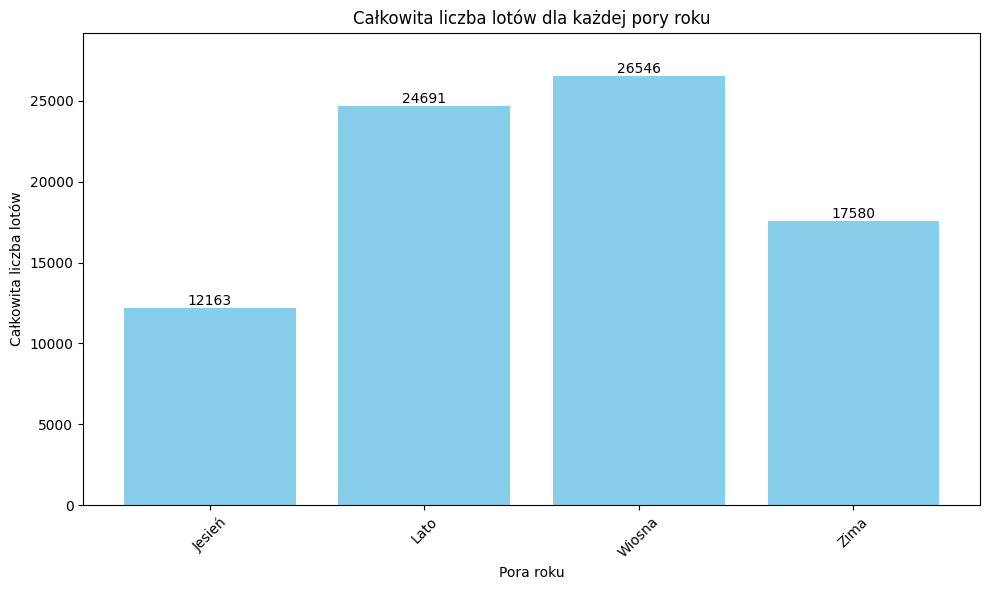

In [6]:
# Utworzenie kolumny 'count' jako liczba lotów
df['count'] = 1

# Grupowanie i sumowanie danych dla każdej pory roku
world_flights_by_season = df.groupby('season')['count'].sum().reset_index()

# Wykres całkowitej liczby lotów dla każdej pory roku
plt.figure(figsize=(10, 6))
plt.bar(world_flights_by_season['season'], world_flights_by_season['count'], color='skyblue')
plt.xlabel('Pora roku')
plt.ylabel('Całkowita liczba lotów')
plt.title('Całkowita liczba lotów dla każdej pory roku')
plt.xticks(rotation=45)
for i, count in enumerate(world_flights_by_season['count']):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)
plt.ylim(0, world_flights_by_season['count'].max() * 1.1)
plt.tight_layout()
plt.show()

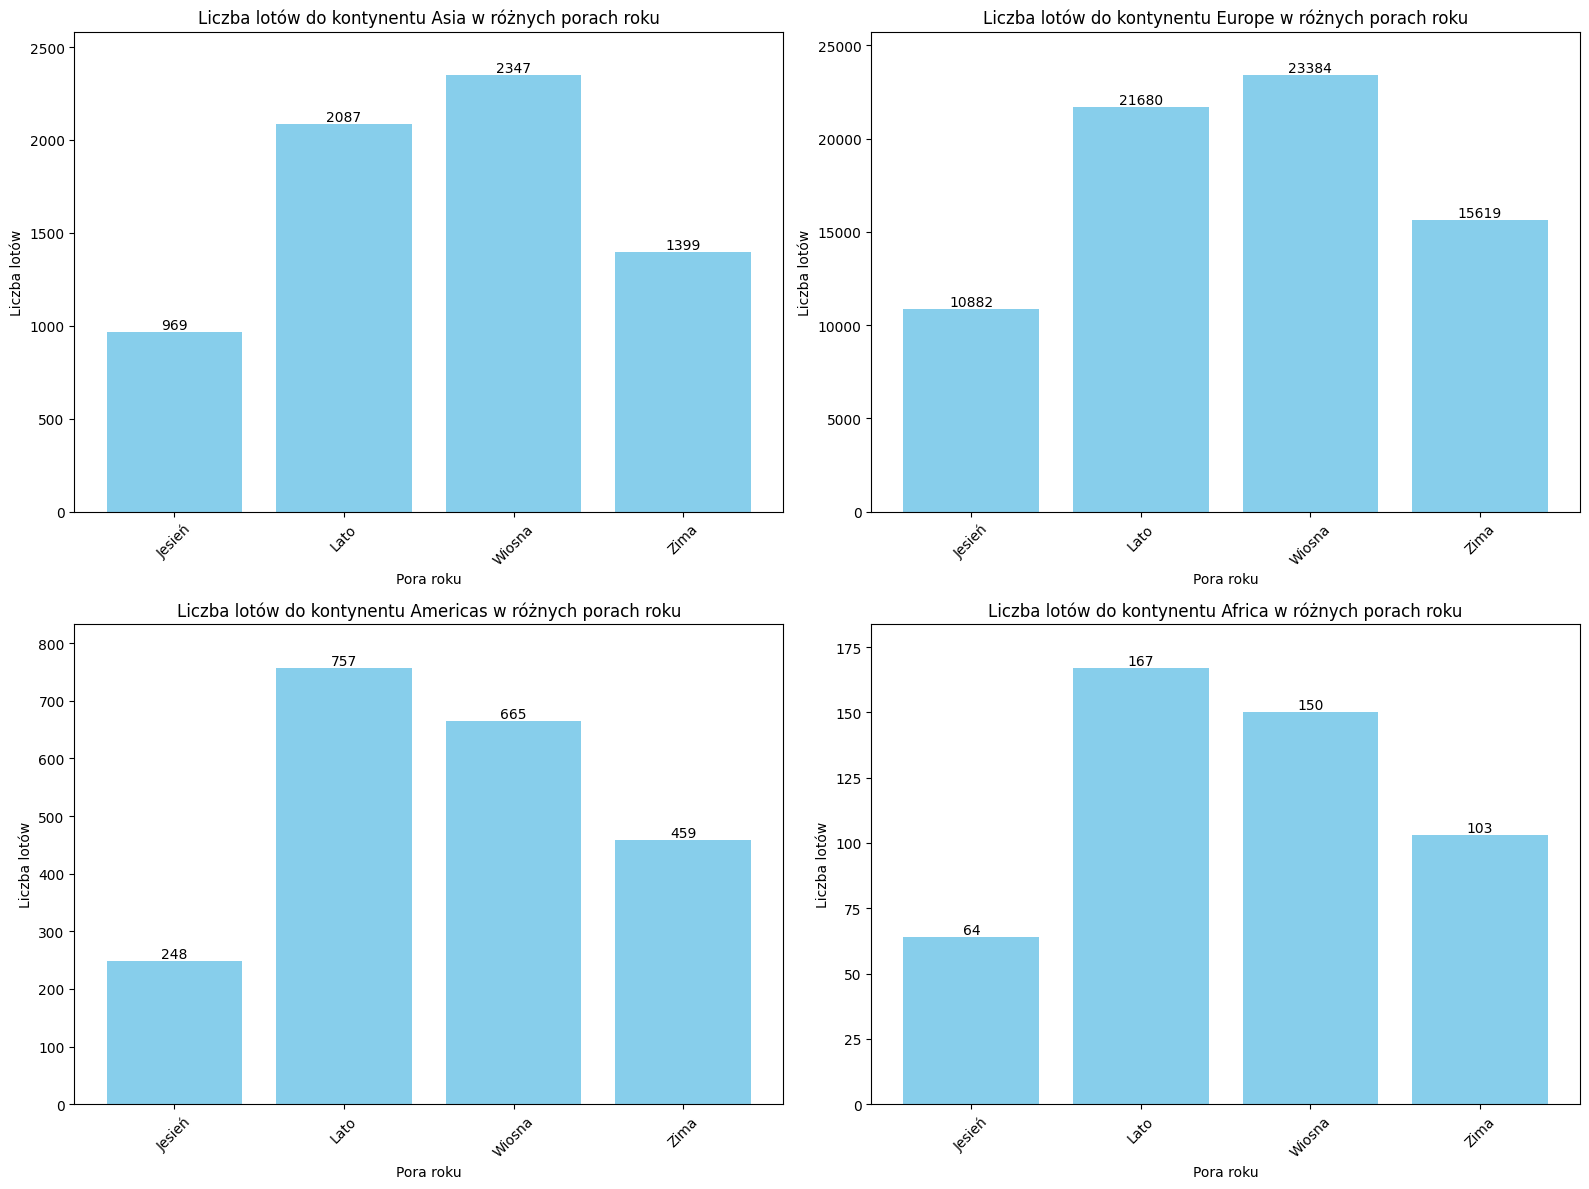

In [7]:
flights_by_season_continent = df.groupby(['season', 'dest_continent']).size().reset_index(name='count')

# Tworzenie wykresu dla każdego kontynentu
continents = df['dest_continent'].unique()
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, continent in zip(axes, continents):
    continent_data = flights_by_season_continent[flights_by_season_continent['dest_continent'] == continent]
    bars = ax.bar(continent_data['season'], continent_data['count'], color='skyblue')
    ax.set_title(f'Liczba lotów do kontynentu {continent} w różnych porach roku')
    ax.set_xlabel('Pora roku')
    ax.set_ylabel('Liczba lotów')
    ax.set_xticks(range(len(continent_data['season'])))
    ax.set_xticklabels(continent_data['season'], rotation=45)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    ax.set_ylim(0, continent_data['count'].max() * 1.1)

plt.tight_layout()
plt.show()

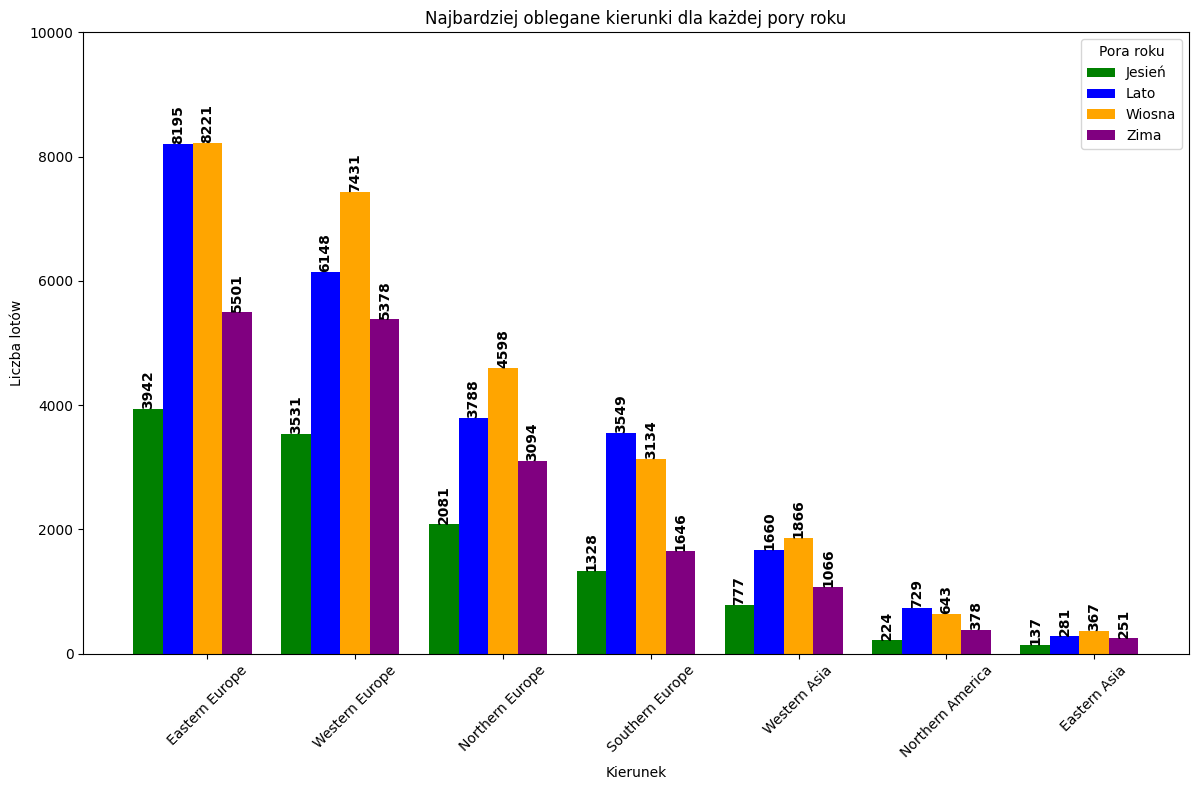

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Przygotowanie danych (tu znajdowałby się wczytywanie danych i przygotowanie DataFrame df)

# Przygotowanie funkcji do wygenerowania wykresu
def plot_most_popular_destinations(df):
    # Znalezienie najbardziej obleganych kierunków dla każdej pory roku
    most_popular_destinations = df.groupby(['season', 'dest_region']).size().reset_index(name='count')
    most_popular_destinations = most_popular_destinations.sort_values(['season', 'count'], ascending=[True, False])
    
    # Wybór 5 najbardziej obleganych kierunków dla każdej pory roku
    top5_destinations = most_popular_destinations.groupby('season').head(7)
    
    # Tworzenie wykresu kolumnowego
    plt.figure(figsize=(12, 8))
    # Ręczne ustawienie kolorów dla różnych pór roku
    colors = ['green', 'blue', 'orange', 'purple']

    for i, (season, data) in enumerate(top5_destinations.groupby('season')):
        bars = plt.bar(np.arange(7) + i * 0.2, data['count'], width=0.2, label=season, color=colors[i])
        for bar in bars:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())), 
                     ha='center', va='bottom', rotation=90, fontsize=10, fontweight='bold')

    plt.xlabel('Kierunek')
    plt.ylabel('Liczba lotów')
    plt.title('Najbardziej oblegane kierunki dla każdej pory roku')
    plt.xticks(np.arange(7) + 0.4, top5_destinations['dest_region'].unique(), rotation=45)
    plt.legend(title='Pora roku', loc='upper right')
    plt.tight_layout()
    plt.ylim(0, 10000)
    plt.show()

# Wywołanie funkcji do generowania wykresu
plot_most_popular_destinations(df)


In [9]:
# Zliczenie ilości lotów z Polski do innych krajów w danym miesiącu
flights_from_poland_to_countries = df[df['orig'] == 'EPWA'].groupby(['season', 'dest_country']).size().reset_index(name='count')

# Wyświetlenie wyników
for season in df['season'].unique():
    for country in df['dest_country'].unique():
        flight_count = flights_from_poland_to_countries[
            (flights_from_poland_to_countries['season'] == season) & 
            (flights_from_poland_to_countries['dest_country'] == country)
        ]
        if not flight_count.empty:
            count = flight_count['count'].values[0]
            print(f"Liczba lotów z lotniska Chopina do kraju {country} w porze roku {season}: {count}")


Liczba lotów z lotniska Chopina do kraju Israel w porze roku Zima: 332
Liczba lotów z lotniska Chopina do kraju Japan w porze roku Zima: 61
Liczba lotów z lotniska Chopina do kraju Qatar w porze roku Zima: 204
Liczba lotów z lotniska Chopina do kraju Great Britain w porze roku Zima: 1027
Liczba lotów z lotniska Chopina do kraju France w porze roku Zima: 717
Liczba lotów z lotniska Chopina do kraju Russia w porze roku Zima: 577
Liczba lotów z lotniska Chopina do kraju Czechia w porze roku Zima: 495
Liczba lotów z lotniska Chopina do kraju Spain w porze roku Zima: 447
Liczba lotów z lotniska Chopina do kraju Netherlands w porze roku Zima: 652
Liczba lotów z lotniska Chopina do kraju Sweden w porze roku Zima: 404
Liczba lotów z lotniska Chopina do kraju Romania w porze roku Zima: 330
Liczba lotów z lotniska Chopina do kraju Austria w porze roku Zima: 419
Liczba lotów z lotniska Chopina do kraju Poland w porze roku Zima: 2404
Liczba lotów z lotniska Chopina do kraju Ireland w porze roku Zi

(0.0, 12249.6)

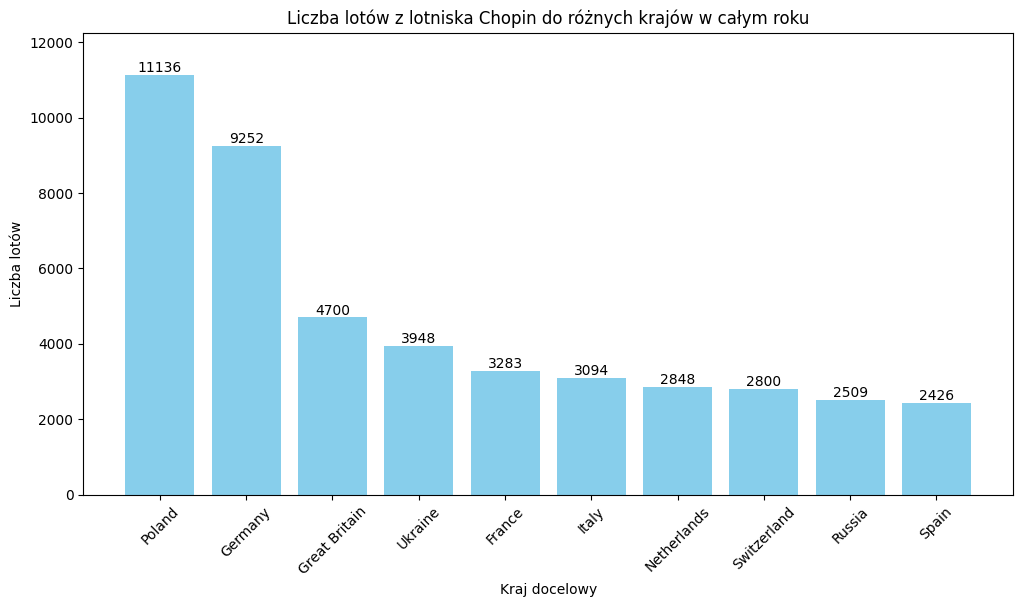

In [10]:
import matplotlib.pyplot as plt

# Zliczenie ilości lotów z Polski do różnych krajów w całym roku
flights_from_poland_to_countries_yearly = df[df['orig'] == 'EPWA'].groupby('dest_country').size().reset_index(name='count')

# Wybór 10 najczęściej uczęszczanych krajów
top_countries_yearly = flights_from_poland_to_countries_yearly.nlargest(10, 'count')

# Wykres kolumnowy
plt.figure(figsize=(12, 6))
bars = plt.bar(top_countries_yearly['dest_country'], top_countries_yearly['count'], color='skyblue')
plt.xlabel('Kraj docelowy')
plt.ylabel('Liczba lotów')
plt.title('Liczba lotów z lotniska Chopin do różnych krajów w całym roku')
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
plt.ylim(0, top_countries_yearly['count'].max() * 1.1)

# Podanie pełnej ścieżki do zapisu wykresu
#file_path = r'C:\Users\Adam\Desktop\ONS\flights_yearly.png'
#plt.savefig(file_path)

# Zamknięcie wykresu bez wyświetlania
#plt.close()


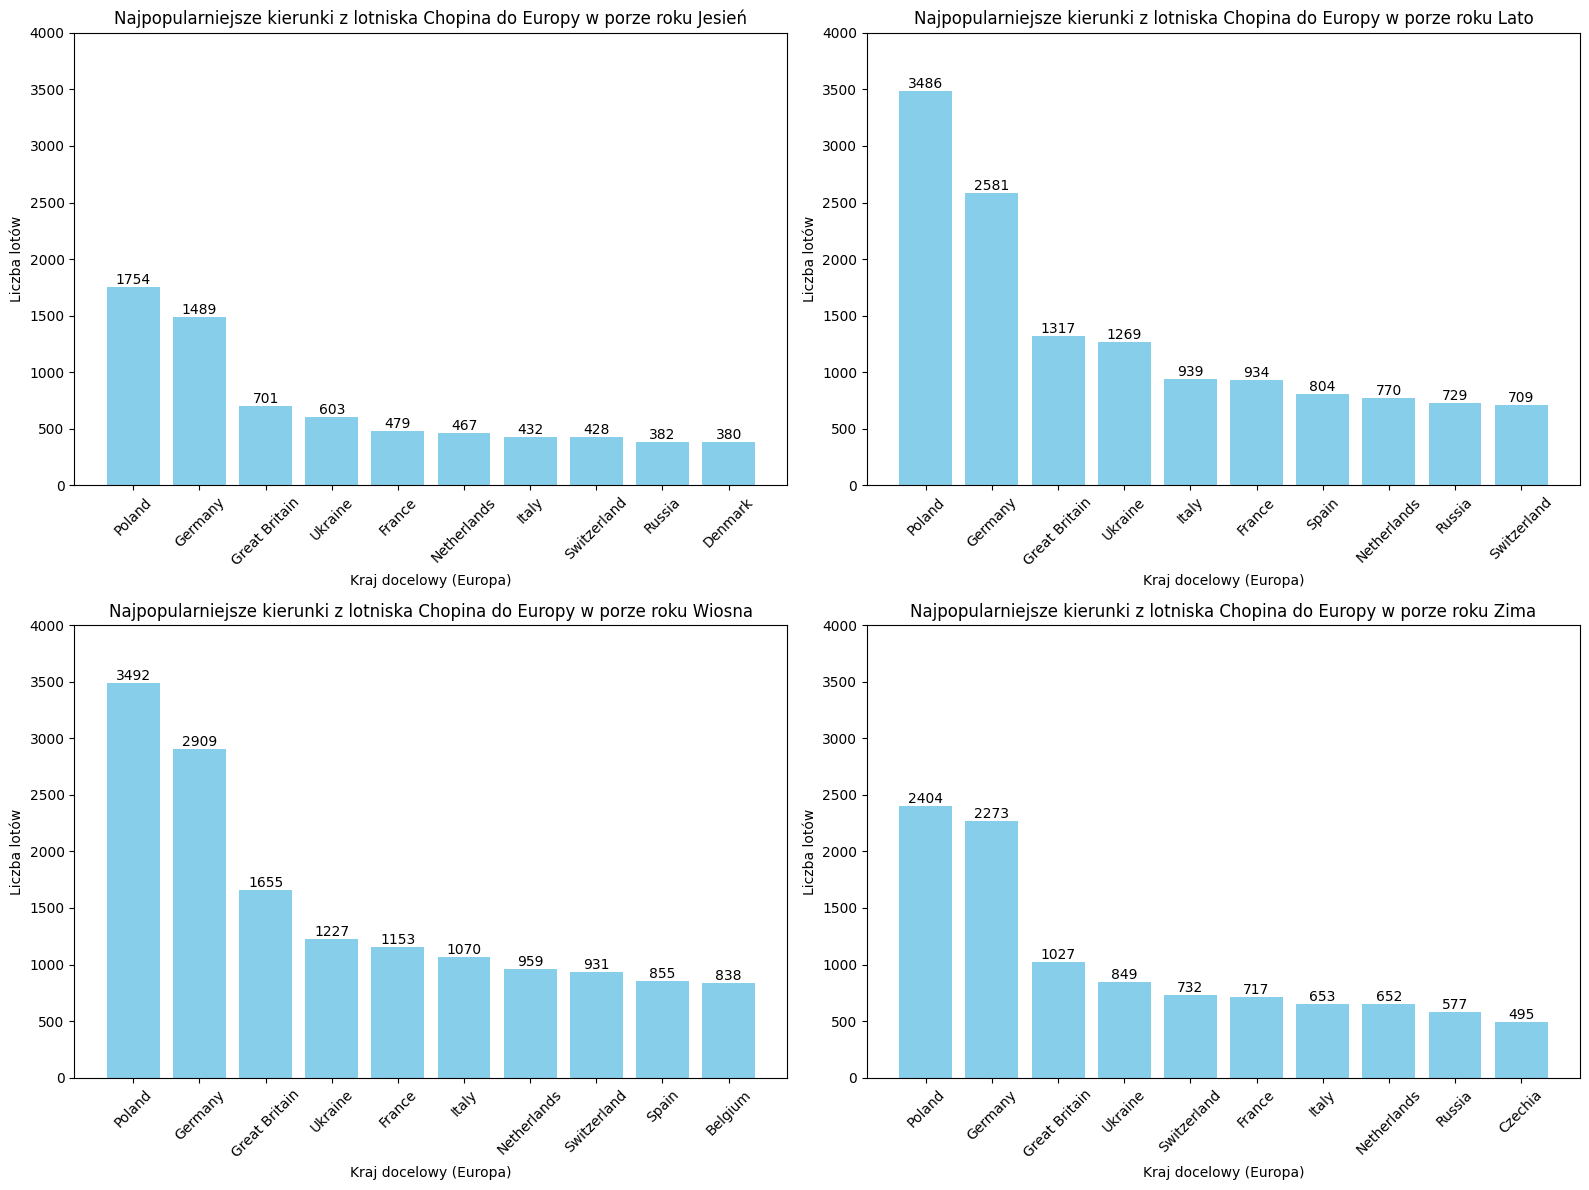

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Agregowanie danych dla krajów europejskich (kraje na kontynencie 'Europe')
flights_to_europe = df[(df['orig'] == 'EPWA') & (df['dest_continent'] == 'Europe')].groupby(['season', 'dest_country']).size().reset_index(name='count')

# Wykresy dla krajów europejskich
seasons = flights_to_europe['season'].unique()
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, season in zip(axes, seasons):
    season_data = flights_to_europe[flights_to_europe['season'] == season].nlargest(10, 'count')
    bars = ax.bar(season_data['dest_country'], season_data['count'], color='skyblue')
    ax.set_title(f'Najpopularniejsze kierunki z lotniska Chopina do Europy w porze roku {season}')
    ax.set_xlabel('Kraj docelowy (Europa)')
    ax.set_ylabel('Liczba lotów')
    ax.set_xticks(range(len(season_data['dest_country'])))
    ax.set_xticklabels(season_data['dest_country'], rotation=45)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    ax.set_ylim(0, 4000)

plt.tight_layout()

plt.savefig(r'A:\repo_git\ONS\data\europe_flights_by_season.png')
plt.show()


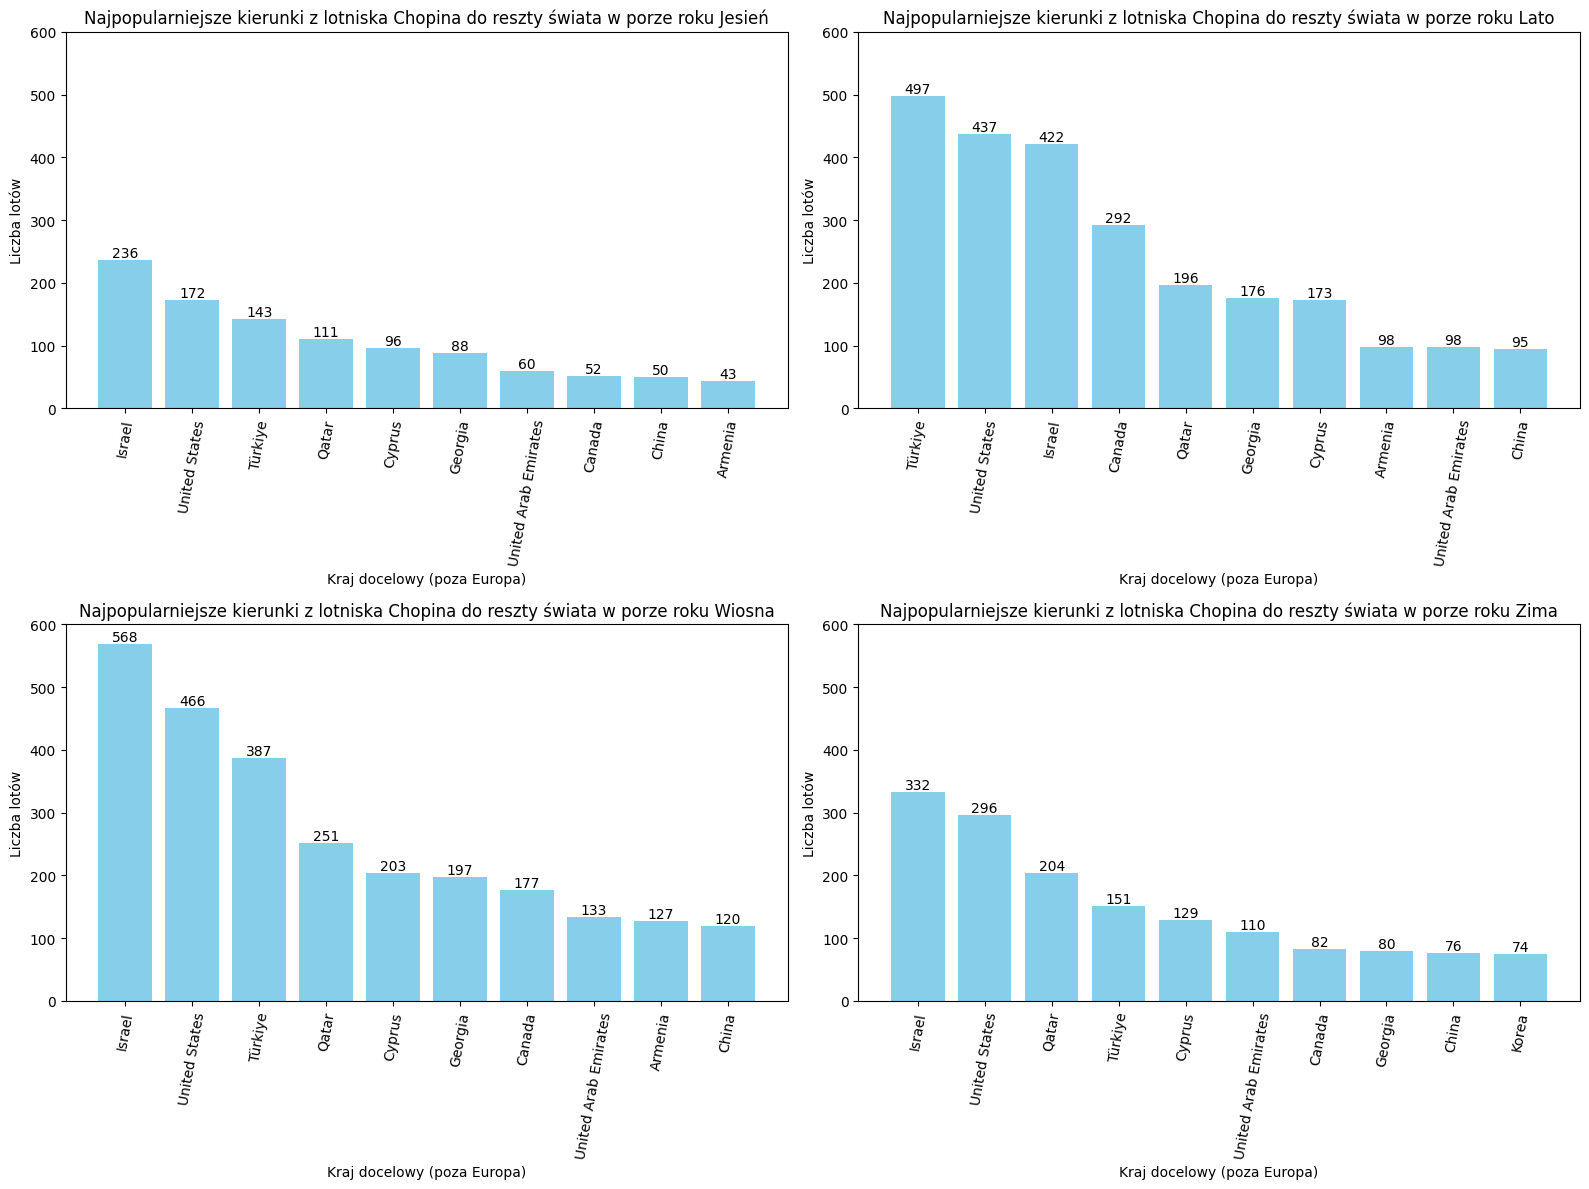

In [12]:
# Agregowanie danych dla reszty świata (kraje poza kontynentem 'Europe')
flights_to_rest_of_world = df[(df['orig'] == 'EPWA') & (df['dest_continent'] != 'Europe')].groupby(['season', 'dest_country']).size().reset_index(name='count')

# Wykresy dla reszty świata
seasons = flights_to_rest_of_world['season'].unique()
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, season in zip(axes, seasons):
    season_data = flights_to_rest_of_world[flights_to_rest_of_world['season'] == season].nlargest(10, 'count')
    bars = ax.bar(season_data['dest_country'], season_data['count'], color='skyblue')
    ax.set_title(f'Najpopularniejsze kierunki z lotniska Chopina do reszty świata w porze roku {season}')
    ax.set_xlabel('Kraj docelowy (poza Europa)')
    ax.set_ylabel('Liczba lotów')
    ax.set_xticks(range(len(season_data['dest_country'])))
    ax.set_xticklabels(season_data['dest_country'], rotation=80)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    ax.set_ylim(0, 600)

plt.tight_layout()

plt.savefig(r'A:\repo_git\ONS\data\rest_of_world_flights_by_season.png')
plt.show()


In [13]:
# Wybór pory roku do wykresu
season_to_plot = 'Winter'  # Można zmienić na dowolną porę roku

# Filtracja danych dla wybranej pory roku
flights_in_season = flights_from_poland_to_countries[flights_from_poland_to_countries['season'] == season_to_plot]

# Wybór 10 najczęściej uczęszczanych krajów
top_countries = flights_in_season.nlargest(10, 'count')

# Wykres kolumnowy
plt.figure(figsize=(12, 6))
bars = plt.bar(top_countries['dest_country'], top_countries['count'], color='skyblue')
plt.xlabel('Kraj docelowy')
plt.ylabel('Liczba lotów')
plt.title(f'Liczba lotów z lotniska Chopin do różnych krajów w porze roku {season_to_plot}')
plt.xticks(rotation=45)
for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
plt.ylim(0, 3800)
#plt.show()
plt.close()


In [14]:
# Wybór pory roku do wykresu
season_to_plot = 'Spring'  # Można zmienić na dowolną porę roku

# Filtracja danych dla wybranej pory roku
flights_in_season = flights_from_poland_to_countries[flights_from_poland_to_countries['season'] == season_to_plot]

# Wybór 10 najczęściej uczęszczanych krajów
top_countries = flights_in_season.nlargest(10, 'count')

# Wykres kolumnowy
plt.figure(figsize=(12, 6))
bars = plt.bar(top_countries['dest_country'], top_countries['count'], color='skyblue')
plt.xlabel('Kraj docelowy')
plt.ylabel('Liczba lotów')
plt.title(f'Liczba lotów z lotniska Chopin do różnych krajów w porze roku {season_to_plot}')
plt.xticks(rotation=45)
for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
plt.ylim(0, 3800)
#plt.show()
plt.close()

In [15]:
# Wybór pory roku do wykresu
season_to_plot = 'Summer'  # Można zmienić na dowolną porę roku

# Filtracja danych dla wybranej pory roku
flights_in_season = flights_from_poland_to_countries[flights_from_poland_to_countries['season'] == season_to_plot]

# Wybór 10 najczęściej uczęszczanych krajów
top_countries = flights_in_season.nlargest(10, 'count')

# Wykres kolumnowy
plt.figure(figsize=(12, 6))
bars = plt.bar(top_countries['dest_country'], top_countries['count'], color='skyblue')
plt.xlabel('Kraj docelowy')
plt.ylabel('Liczba lotów')
plt.title(f'Liczba lotów z lotniska Chopin do różnych krajów w porze roku {season_to_plot}')
plt.xticks(rotation=45)
for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
plt.ylim(0, 3800)

plt.close()

In [16]:
# Wybór pory roku do wykresu
season_to_plot = 'Autumn'  # Można zmienić na dowolną porę roku

# Filtracja danych dla wybranej pory roku
flights_in_season = flights_from_poland_to_countries[flights_from_poland_to_countries['season'] == season_to_plot]

# Wybór 10 najczęściej uczęszczanych krajów
top_countries = flights_in_season.nlargest(10, 'count')

# Wykres kolumnowy
plt.figure(figsize=(12, 6))
bars = plt.bar(top_countries['dest_country'], top_countries['count'], color='skyblue')
plt.xlabel('Kraj docelowy')
plt.ylabel('Liczba lotów')
plt.title(f'Liczba lotów z lotniska Chopin do różnych krajów w porze roku {season_to_plot}')
plt.xticks(rotation=45)
plt.ylim(0, 3800)
for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
#plt.show()
plt.close()

In [17]:
# Zliczenie ilości lotów z Polski do roznych kontynentow w kazdym miesiacu
flights_from_poland_to_continents = df[df['orig'] == 'EPWA'].groupby(['season', 'dest_continent']).size().reset_index(name='count')

# Wyświetlenie wyników
for season in df['season'].unique():
    for continent in df['dest_continent'].unique():
        flight_count = flights_from_poland_to_continents[
            (flights_from_poland_to_continents['season'] == season) & 
            (flights_from_poland_to_continents['dest_continent'] == continent)
        ]
        if not flight_count.empty:
            count = flight_count['count'].values[0]
            print(f"Liczba lotów z lotniska Chopin do kontynentu {continent} w miesiącu {season}: {count}")

Liczba lotów z lotniska Chopin do kontynentu Asia w miesiącu Zima: 1399
Liczba lotów z lotniska Chopin do kontynentu Europe w miesiącu Zima: 15619
Liczba lotów z lotniska Chopin do kontynentu Americas w miesiącu Zima: 459
Liczba lotów z lotniska Chopin do kontynentu Africa w miesiącu Zima: 103
Liczba lotów z lotniska Chopin do kontynentu Asia w miesiącu Wiosna: 2347
Liczba lotów z lotniska Chopin do kontynentu Europe w miesiącu Wiosna: 23384
Liczba lotów z lotniska Chopin do kontynentu Americas w miesiącu Wiosna: 665
Liczba lotów z lotniska Chopin do kontynentu Africa w miesiącu Wiosna: 150
Liczba lotów z lotniska Chopin do kontynentu Asia w miesiącu Lato: 2087
Liczba lotów z lotniska Chopin do kontynentu Europe w miesiącu Lato: 21680
Liczba lotów z lotniska Chopin do kontynentu Americas w miesiącu Lato: 757
Liczba lotów z lotniska Chopin do kontynentu Africa w miesiącu Lato: 167
Liczba lotów z lotniska Chopin do kontynentu Asia w miesiącu Jesień: 969
Liczba lotów z lotniska Chopin do 

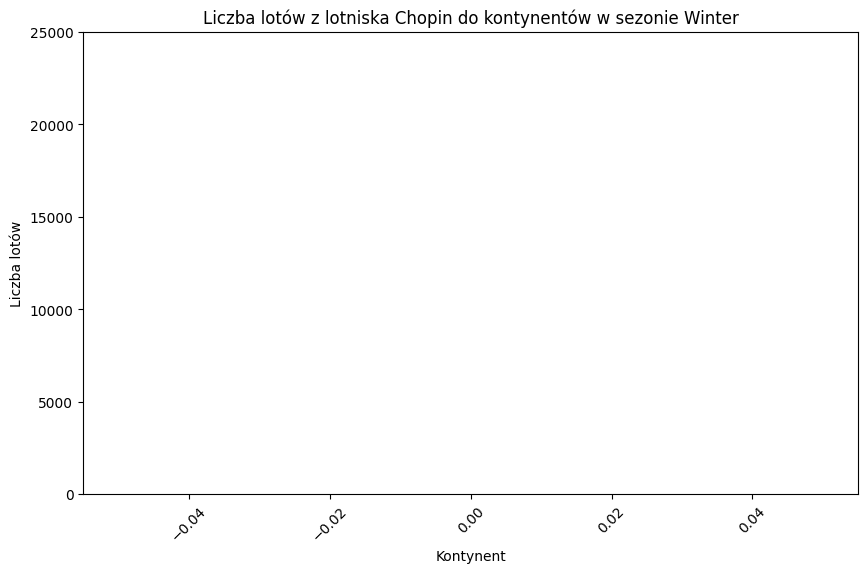

In [18]:
# Przygotowanie danych do wykresu dla wybranej pory roku
season = 'Winter'
winter_flights_continent_count = flights_from_poland_to_continents[flights_from_poland_to_continents['season'] == season]

# Tworzenie wykresu kolumnowego
plt.figure(figsize=(10, 6))
bars = plt.bar(winter_flights_continent_count['dest_continent'], winter_flights_continent_count['count'], color='skyblue')
plt.title(f'Liczba lotów z lotniska Chopin do kontynentów w sezonie {season}')
plt.xlabel('Kontynent')
plt.ylabel('Liczba lotów')
plt.xticks(rotation=45)
plt.ylim(0, 25000)
# Dodanie etykiet nad każdą kolumną
for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')


# Wyświetlenie wykresu
plt.show()
#plt.close()

In [19]:
season = 'Spring'
spring_flights_continent_count = flights_from_poland_to_continents[flights_from_poland_to_continents['season'] == season]

# Tworzenie wykresu kolumnowego
plt.figure(figsize=(10, 6))
bars = plt.bar(spring_flights_continent_count['dest_continent'], spring_flights_continent_count['count'], color='skyblue')
plt.title(f'Liczba lotów z lotniska Chopin do kontynentów w sezonie {season}')
plt.xlabel('Kontynent')
plt.ylabel('Liczba lotów')
plt.xticks(rotation=45)
plt.ylim(0, 25000)
# Dodanie etykiet nad każdą kolumną
for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

# Wyświetlenie wykresu
#plt.show()
plt.close()

In [20]:
season = 'Summer'
summer_flights_continent_count = flights_from_poland_to_continents[flights_from_poland_to_continents['season'] == season]

# Tworzenie wykresu kolumnowego
plt.figure(figsize=(10, 6))
bars = plt.bar(summer_flights_continent_count['dest_continent'], summer_flights_continent_count['count'], color='skyblue')
plt.title(f'Liczba lotów z lotniska Chopin do kontynentów w sezonie {season}')
plt.xlabel('Kontynent')
plt.ylabel('Liczba lotów')
plt.xticks(rotation=45)
plt.ylim(0, 25000)

# Dodanie etykiet nad każdą kolumną
for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

# Wyświetlenie wykresu
#plt.show()
plt.close()

In [21]:
season = 'Autumn'
autumn_flights_continent_count = flights_from_poland_to_continents[flights_from_poland_to_continents['season'] == season]

# Tworzenie wykresu kolumnowego
plt.figure(figsize=(10, 6))
bars = plt.bar(autumn_flights_continent_count['dest_continent'], autumn_flights_continent_count['count'], color='skyblue')
plt.title(f'Liczba lotów z lotniska Chopin do kontynentów w sezonie {season}')
plt.xlabel('Kontynent')
plt.ylabel('Liczba lotów')
plt.xticks(rotation=45)
plt.ylim(0, 25000)  # Ustawienie górnej granicy osi y z większą przestrzenią

# Dodanie etykiet nad każdą kolumną
for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

# Wyświetlenie wykresu
#plt.show()
plt.close()

In [22]:
# Zliczenie ilości lotów z Polski do różnych regionów w każdej porze roku
flights_from_poland_to_regions = df[df['orig'] == 'EPWA'].groupby(['season', 'dest_region']).size().reset_index(name='count')

# Wyświetlenie wyników
for season in df['season'].unique():
    for region in df['dest_region'].unique():
        flight_count = flights_from_poland_to_regions[
            (flights_from_poland_to_regions['season'] == season) & 
            (flights_from_poland_to_regions['dest_region'] == region)
        ]
        if not flight_count.empty:
            count = flight_count['count'].values[0]
            print(f"Liczba lotów z lotniska Chopin do regionu {region} w porze roku {season}: {count}")


Liczba lotów z lotniska Chopin do regionu Western Asia w porze roku Zima: 1066
Liczba lotów z lotniska Chopin do regionu Eastern Asia w porze roku Zima: 251
Liczba lotów z lotniska Chopin do regionu Northern Europe w porze roku Zima: 3094
Liczba lotów z lotniska Chopin do regionu Western Europe w porze roku Zima: 5378
Liczba lotów z lotniska Chopin do regionu Eastern Europe w porze roku Zima: 5501
Liczba lotów z lotniska Chopin do regionu Southern Europe w porze roku Zima: 1646
Liczba lotów z lotniska Chopin do regionu Caribbean w porze roku Zima: 81
Liczba lotów z lotniska Chopin do regionu Northern America w porze roku Zima: 378
Liczba lotów z lotniska Chopin do regionu Central Asia w porze roku Zima: 46
Liczba lotów z lotniska Chopin do regionu Northern Africa w porze roku Zima: 89
Liczba lotów z lotniska Chopin do regionu South-eastern Asia w porze roku Zima: 36
Liczba lotów z lotniska Chopin do regionu Sub-Saharan Africa w porze roku Zima: 14
Liczba lotów z lotniska Chopin do regi

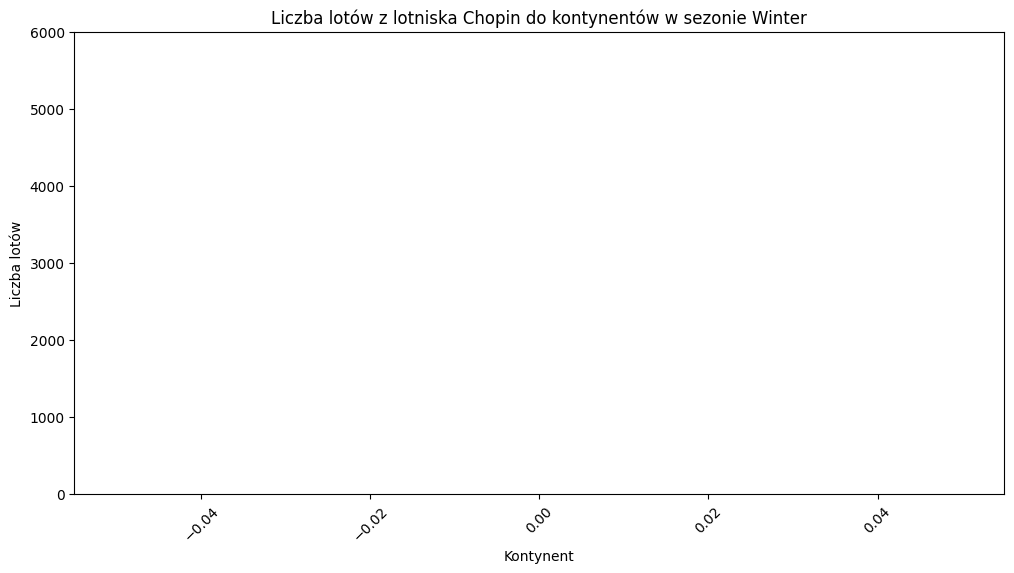

In [23]:
# Przygotowanie danych do wykresu dla wybranej pory roku
season = 'Winter'
winter_flights_region_count = flights_from_poland_to_regions[flights_from_poland_to_regions['season'] == season]

# Tworzenie wykresu kolumnowego
plt.figure(figsize=(12, 6))
bars = plt.bar(winter_flights_region_count['dest_region'], winter_flights_region_count['count'], color='skyblue')
plt.title(f'Liczba lotów z lotniska Chopin do kontynentów w sezonie {season}')
plt.xlabel('Kontynent')
plt.ylabel('Liczba lotów')
plt.xticks(rotation=45)
plt.ylim(0, 6000)
# Dodanie etykiet nad każdą kolumną
for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')


# Wyświetlenie wykresu
plt.show()
#plt.close()

In [24]:
# Tworzenie wykresu kolumnowego
plt.figure(figsize=(12, 6))
bars = plt.bar(unique_countries_per_month['month'], unique_countries_per_month['unique_countries'], color='skyblue')

# Dodanie etykiet nad każdą kolumną
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.xlabel('Miesiąc')
plt.ylabel('Liczba krajów docelowych')
plt.title('Liczba krajów docelowych w każdym miesiącu')
plt.xticks(range(1, 13))  # Ustawienie etykiet osi X na miesiące od 1 do 12
plt.grid(True, axis='y')
plt.show()


NameError: name 'unique_countries_per_month' is not defined

<Figure size 1200x600 with 0 Axes>